# Session 3. Web Structure Mining: Communities and Link Prediction

#### From Clément Bosc & Cédric Lespagnol

In this practical work, we will focus on Web Structure Mining in which data are interconnected and considered as a network to mine. We will first check if a network satisfies to constraints to be considered as a complex network and then, we will determine how important nodes are within a network.

In [104]:
%matplotlib inline

import networkx as nx
from networkx.algorithms import community as nxcommunity
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

### First download the dataset

In [105]:
pathData = "lesmis.gml"

### Then, navigate through the documentation of the networkx package and find how to load networks in the GML format
You can have a look to this file by openning it with a basic text editor. Note that the graph is undirected.

In [106]:
g = nx.read_gml(pathData)

## Community detection
In this section, we will focus on community detection algorithm. For this, have a look to the networkx package documentation and apply the following community detection algorithms:

1. Kernighan–Lin bipartition algorithm
2. Percolation method
3. Fluid communities algorithm
4. Girvan-Newman method

When the number of communities to detect has to be specified as a parameter, you will use the coverage metric to select the appropriate number (ranging from 2 to 5).

Finally, for each community algorithm, you will add an attribute to each node of the graph. The value of the attribute will be the identifier of the community tne node belongs to (ranging from 0 to nbCommunity -1).

In [107]:
community = {}

def dictite_to_dict(d):
    s = []
    for part in d:
        a = set()
        for i in part:
            a.add(i)
        s.append(a)
    return s

#### 1.Kernighan–Lin bipartition algorithm

In [108]:
community['bipartition'] = dictite_to_dict(nxcommunity.kernighan_lin.kernighan_lin_bisection(g))

#### 2. Percolation method

In [109]:
community['percolation'] = dictite_to_dict(nxcommunity.k_clique_communities(g, 3))

#### 3. Fluid communities algorithm

In [110]:
res = {}
partitions = {}
for i in range(2, 6):
    part = list(nxcommunity.asyn_fluidc(g, i))
    res[i] = nxcommunity.quality.coverage(g, dictite_to_dict(part))
    partitions[i] = part
    
community['fluid'] = dictite_to_dict(partitions[max(res, key=res.get)])

#### 4. Girvan-Newman method

In [111]:
res = {}
grivan = list(nxcommunity.girvan_newman(g))
for i in range(0, 5):
    res[i] = nxcommunity.quality.coverage(g, dictite_to_dict(grivan[i]))

community['girvan'] = dictite_to_dict(grivan[max(res, key=res.get)])

In [112]:
for k, v in community.items():
    for c_num in range(len(v)):
        for n in v[c_num]:
            g.node[n][k] = c_num

## Community visualization
We will now visualize the result of the communication detection algorithm. For this, we start by filtering out some nodes from the visualisation. Particularly, we would like to filter out nodes that do not belong to any communities according to the percolation method. To do so, you need to create a list that contains the label of nodes belonging to a community according to the percolation method. You can use the following dictionnary to set the visualisation options.

```json
options = {
    'node_color' : colorNode, # a list that contains the community id for the nodes we want to plot
    'node_size' : 10000, 
    'cmap' : plt.get_cmap("jet"),
    'node_shape' : 'o',
    'with_labels' : True, 
    "width" : 0.1, 
    "font_size" : 15,
    "nodelist" : nodes, # A list that contains the labels of the nodes we want to plot
    "alpha" : 0.8   
}

plt.figure(figsize=(18,18))
nx.draw(g,**options)```

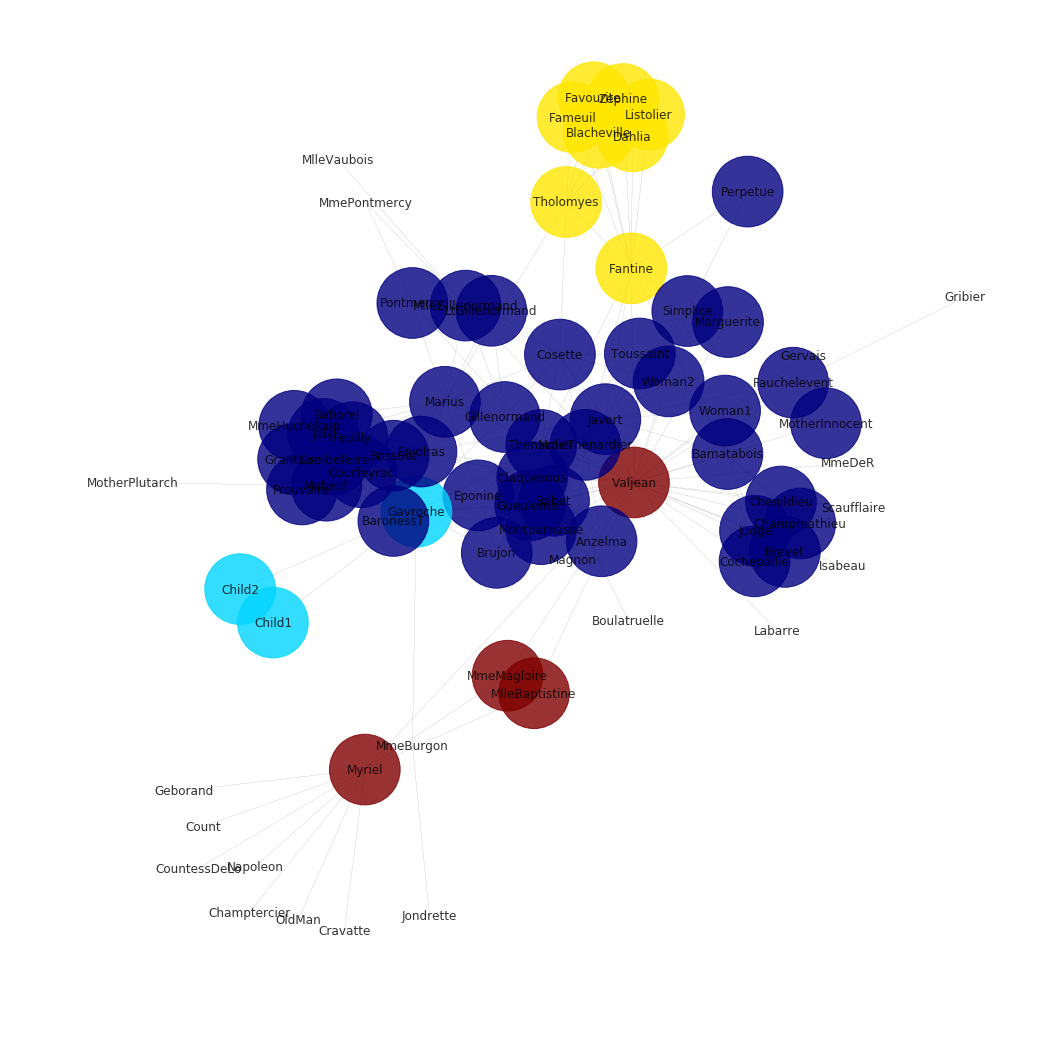

In [113]:
#remove nodes without k_clique

node_list = []
node_color = []

percoAttr = nx.get_node_attributes(g, 'percolation')
percoAttrList = list(percoAttr)

for node in percoAttrList:
    if (percoAttr[node] >= 0):
        node_color.append(float(percoAttr[node]))
        node_list.append(node)
        
options = {
    'node_color' : node_color, # a list that contains the community id for the nodes we want to plot
    'node_size' : 5000, 
    'cmap' : plt.get_cmap("jet"),
    'node_shape' : 'o',
    'with_labels' : True, 
    "width" : 0.1, 
    "font_size" : 12,
    "nodelist" : node_list, # A list that contains the labels of the nodes we want to plot
    "alpha" : 0.8   
}

plt.figure(figsize=(14,14))
nx.draw(g,**options)

## Link prediction
We now focus on link prediction and tackle this problem using 2 methods: unsupervised and supervised.

### Unsupervised
We start by the unsupervised perspective. We first build a Panda Series from the edges of the graph and then select a sample of size 50 from this series.

In [114]:
sizeTestSet = 50

testSet = pd.Series(g.edges()).sample(sizeTestSet)

Then, in order to see if metrics we have discussed in this lecture are effective, edges in the sample have to be removed from a copied version of g.

In [115]:
g2 = g.copy()

for e in testSet:
    g2.remove_edge(e[0], e[1])

We can calculate some metrics to determine the strength of a potential link between two nodes. We will then select the top 50 potential links and compare them to the one we have just removed to assess how effective are these metrics over this dataset. You will apply the following methodology:

1. Calculate the metrics for all non-existant pairs of nodes
2. Build a dataframe to store these scores and extract the top 50 potential links
3. Use the `isin` function over the sample of edges to count how many removed edges are in the top 50

Repeat this process with the following link prediction metrics :

1. Resource allocation index
2. Jaccard coefficient
3. Adamic-Adar index
4. Preferential attachment

In [116]:
link_prediction_df = pd.DataFrame(
    np.zeros((len(list(nx.non_edges(g2))), 4)), 
    columns=['resource', 'jaccard', 'adamic', 'preferential'],
    index=pd.MultiIndex.from_tuples(list(nx.non_edges(g2)))) #nx.resource_allocation_index(g2, nx.non_edges(g2)))

link_prediction_df['resource'] = pd.Series([x[2] for x in nx.resource_allocation_index(g2, nx.non_edges(g2))], index=link_prediction_df.index)
link_prediction_df['jaccard'] = pd.Series([x[2] for x in nx.jaccard_coefficient(g2, nx.non_edges(g2))], index=link_prediction_df.index)
link_prediction_df['adamic'] = pd.Series([x[2] for x in nx.adamic_adar_index(g2, nx.non_edges(g2))], index=link_prediction_df.index)
link_prediction_df['preferential'] = pd.Series([x[2] for x in nx.preferential_attachment(g2, nx.non_edges(g2))], index=link_prediction_df.index)

link_prediction_df.head()

resource   jaccard    adamic  preferential
Joly Fameuil              0.0  0.000000  0.000000            54
     Woman2               0.0  0.000000  0.000000            27
     MlleBaptistine       0.0  0.000000  0.000000            18
     Cochepaille          0.0  0.000000  0.000000            54
     Eponine              0.2  0.142857  0.868589            63

In [117]:
top = {}
for k in ['resource', 'jaccard', 'adamic', 'preferential']:
    top[k] = link_prediction_df.sort_values(by=k, ascending=False)[:50].index.values

top_df = pd.DataFrame(top)
top_df.head()

,adamic,jaccard,preferential,resource
0,"(Joly, Bahorel)","(Cravatte, Geborand)","(Valjean, Gavroche)","(Fantine, Valjean)"
1,"(Fantine, Valjean)","(Woman2, Toussaint)","(Fantine, Valjean)","(MmeThenardier, Thenardier)"
2,"(MmeThenardier, Thenardier)","(Napoleon, Geborand)","(Valjean, Bahorel)","(Joly, Bahorel)"
3,"(Combeferre, Gavroche)","(Fameuil, Favourite)","(Valjean, Mabeuf)","(Fameuil, Favourite)"
4,"(Joly, Bossuet)","(Count, Cravatte)","(Courfeyrac, Valjean)","(Combeferre, Gavroche)"


In [118]:
count = {}
for k in ['resource', 'jaccard', 'adamic', 'preferential']:
    count[k] = (testSet.isin(top_df[k]) == True).sum()
print(count)

{'resource': 13, 'jaccard': 5, 'adamic': 13, 'preferential': 4}


### Supervised

From previous results, it is hard to say that the above-used features are outstanding... We now try to combine them in a supervised setting. To achieve this, please carrefully apply the following procedure.

1/ Set a variable sizeTestSet to 50, a variable sizeTrainingPositiveSet to the number of edges in g minus the size of the test set and, a variable sizeTrainingSet to 2 times the size of the positive training set.

In [119]:
sizeTestSet = 50
sizeTrainingPositiveSet = len(g.edges()) - sizeTestSet
sizeTrainingSet = 2 * sizeTrainingPositiveSet

2/ We will build the positive training set and the test set. To do so, first copy the graph `g` into `g_training`. Second, generate a sample of size `sizeTestSet`, denoted by `sampleTest`, from the series of edges of `g_training`. This sample will be your test set (we will apply our model on it and hope the existence of a link will be predicted). Then, remove from `g_training` the edges in sampleTest. Finally, convert the remaining edges as a series.

In [120]:
g_training = g.copy()
sampleTest = pd.Series(g_training.edges()).sample(sizeTestSet)

for e in sampleTest:
    g_training.remove_edge(e[0], e[1])
    
samplePositiveTraining = pd.Series(g_training.edges())

3/ To balance the training set, we will randomly pick pairs of unconnected vertices (negative class). The number of pairs should be equal to the number of considered connections (positive class) in the training set. Find a way to generate this negative training set and name it `sampleNegativeTraining`.

In [121]:
import random

sampleNegativeTraining = pd.Series(random.sample(list(nx.non_edges(g_training)), sizeTrainingPositiveSet))

4/ It is now time to calculate the features for each member of the training and test sets. The features list is presented below:

1. size of the shortest path
2. number of shortest paths
3. for each community algorithm, does the vertices associated to a connection belongs to the same community (except -1) : 1 or 0
4. for each link prediction algorithm, the strength of the connection

The feature list is:

```json
features = [
    "lShortestPath",
    "nbShortestPath",
    "bipartition",
    "percolation",
    "fluid",
    "girvan",
    "resource",
    "jaccard",
    "adamic",
    "preferential",
    "class"
]```

In [122]:
features = [
    "lShortestPath",
    "nbShortestPath",
    "bipartition",
    "percolation",
    "fluid",
    "girvan",
    "resource",
    "jaccard",
    "adamic",
    "preferential",
    "class"
]

5/ Use the following code (and modify it if necessary) to create 2 empty data frames (one for the training set and the other for the test set).

In [123]:
sampleTraining = pd.concat([samplePositiveTraining,sampleNegativeTraining],ignore_index=True)
dfTraining = pd.DataFrame(np.zeros((sizeTrainingSet, 11)), columns=features, index= pd.MultiIndex.from_tuples(sampleTraining))
dfTest = pd.DataFrame(np.zeros((sizeTestSet, 11)), columns=features, index= pd.MultiIndex.from_tuples(sampleTest))

6/ Write a function `calculateFeatures` with the following specifications:

INPUT :

* `sample`: the series of edges you want to calculate the feature values
* `df`: the data frame you want to update
* `training`: True if edges in sample are in the training set and False otherwise
* `positive`: True if training = True and positive instances are considered
    
OUTPUT
* No output

OBJECTIVE

Update `df` (the rows such that their indexes are in `sample`) with the feature values

In [124]:
def calculateFeatures(sample, df, training, positive):
    
    link_prediction_training_df = pd.DataFrame(np.zeros((len(sample), 4)), 
                                               columns=['resource', 'jaccard', 'adamic', 'preferential'],
                                               index=pd.MultiIndex.from_tuples(sample))

    link_prediction_training_df['resource'] = pd.Series(
        [x[2] for x in nx.resource_allocation_index(g, sample)], 
        index=link_prediction_training_df.index)
    link_prediction_training_df['jaccard'] = pd.Series(
        [x[2] for x in nx.jaccard_coefficient(g, sample)], 
        index=link_prediction_training_df.index)
    link_prediction_training_df['adamic'] = pd.Series(
        [x[2] for x in nx.adamic_adar_index(g, sample)], 
        index=link_prediction_training_df.index)
    link_prediction_training_df['preferential'] = pd.Series(
        [x[2] for x in nx.preferential_attachment(g, sample)], 
        index=link_prediction_training_df.index)
    
    for n1,n2 in sample:
        if nx.has_path(g, n1, n2):
            df.lShortestPath[(n1,n2)] = nx.shortest_path_length(g, n1, n2)
            df.nbShortestPath[(n1,n2)] = len(list(nx.all_shortest_paths(g, n1, n2)))
        else:
            df.lShortestPath[(n1,n2)] = 0
            df.nbShortestPath[(n1,n2)] = 0
            
        for algo in ["bipartition", "percolation","fluid", "girvan"]:
            df[algo][(n1,n2)] = 1 if (algo in g.node[n1] and 
                                      algo in g.node[n2] and 
                                      g.node[n1][algo] == g.node[n2][algo]) else 0
            
        for link_pred_algo in ['resource', 'jaccard', 'adamic', 'preferential']:
            df[link_pred_algo][(n1,n2)] = link_prediction_training_df[link_pred_algo][(n1,n2)] 
            
        if training:
            df['class'][(n1,n2)] = (1 if positive else -1)
            

7/ Call the function with the apropriate parameters (tips: it should be called 3 times)

In [125]:
calculateFeatures(samplePositiveTraining, dfTraining, True, True)
calculateFeatures(sampleNegativeTraining, dfTraining, True, False)
calculateFeatures(sampleTest, dfTest, False, False)

8/ Apply the following code and conclude:

In [137]:
from sklearn.tree import DecisionTreeClassifier

features = list(dfTraining.columns[:10])
y = dfTraining["class"]
X = dfTraining[features]
dt = DecisionTreeClassifier(min_samples_split=10, random_state=99)
dt.fit(X, y)
y_pred = dt.predict(dfTest[features])
y_true = np.full((50), 1)

print(y_pred)

[ 1. -1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [139]:
import sklearn
sklearn.metrics.accuracy_score(y_true, y_pred)

0.86

Our accuracy score is 86%, so we can conclude that that the **supervised method** with link prediction & commuity detection algorithms and shortest path values as features is a relatively good method to predict link that should exists between nodes in our graph.